# Solving Maximum independent set problem with Rydberg atoms

In this example notebook, we shall demonstrate how to solve the maximum independent set (MIS) problem with Rydberg atoms. 

## Introduction to MIS

![MIS_graph.png](MIS_graph.png)

## Solving MIS with Rydberg atoms

We begin by importing the necessary packages.



In [1]:
import numpy as np
import matplotlib.pyplot as plt

from braket.ahs.atom_arrangement import AtomArrangement


from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation

from utils import show_register, show_global_drive, show_local_shift, show_final_avg_density, get_drive, get_shift, show_drive_and_shift

from braket.devices import LocalSimulator

## Embed the graph into the Rydberg system

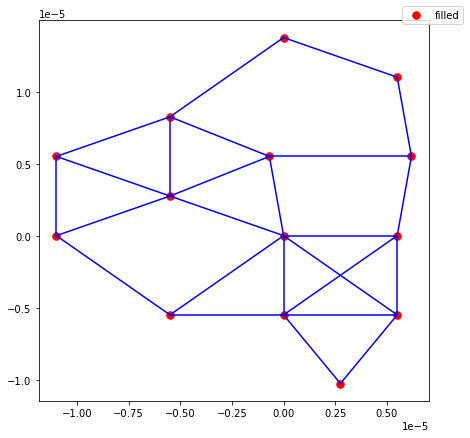

In [2]:
register = AtomArrangement()
a = 5.5e-6  # in meters 

coords = [
    [0, 5/2], [1, 2], [-1, 3/2], [-2, 1], [-1/8, 1],
    [9/8, 1], [-1, 1/2], [-2, 0], [0, 0], [1, 0],
    [-1, -1], [0, -1], [1, -1], [1/2, -(1+np.sqrt(3)/2)]]

coords = np.array(coords) * a

for coord in coords:
    register.add((coord[0], coord[1]))

show_register(register, blockade_radius=np.sqrt(2) * a)

In [38]:
# amplitude_min = 0       
# amplitude_max = 24e6

# detuning_min = -24e6
# detuning_max = 60e6

amplitude_min = 0       
amplitude_max = 6.3e6

detuning_min = -12e6
detuning_max = 30e6

time_max = 4e-6  # s
time_ramp = 5e-7  # s

time_points = [0, time_ramp, time_max - time_ramp, time_max]
amplitude_values = [amplitude_min, amplitude_max, amplitude_max, amplitude_min]
detuning_values = [detuning_min, detuning_min, detuning_max, detuning_max]
phase_values = [0, 0, 0, 0]

drive = get_drive(time_points, amplitude_values, detuning_values, phase_values)


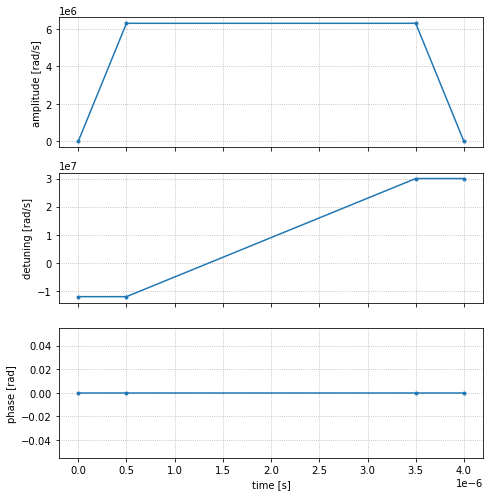

In [39]:
show_global_drive(drive)

In [40]:
ahs_program = AnalogHamiltonianSimulation(
    register=register, 
    hamiltonian=drive
)

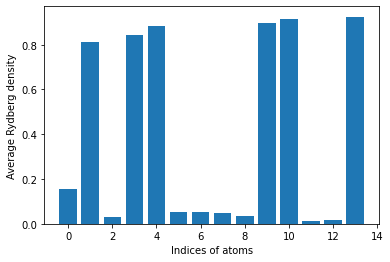

In [42]:
device = LocalSimulator("braket_ahs")
result = device.run(ahs_program, blockade_radius=np.sqrt(2) * a, shots=1000).result()
# result = device.run(ahs_program, shots=100, progress_bar=True).result()

show_final_avg_density(result)

List out the two most common output with largest prob. 

## Local detuning

In [24]:
time_points_shift = [0.0, time_max]
values_shift = [detuning_min, detuning_min]
pattern = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

shift = get_shift(time_points_shift, values_shift, pattern)


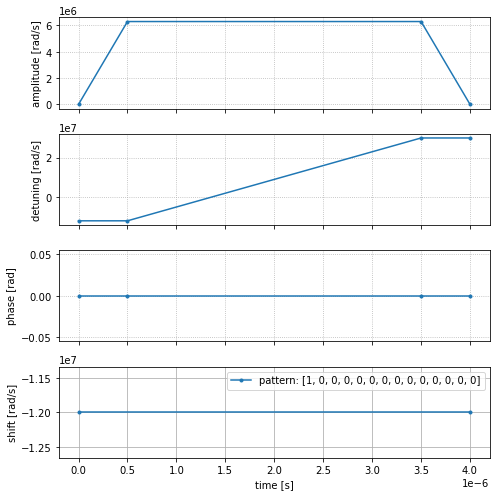

In [25]:
show_drive_and_shift(drive, shift)

In [26]:
ahs_program_with_shift = AnalogHamiltonianSimulation(
    register=register, 
    hamiltonian=drive + shift
)

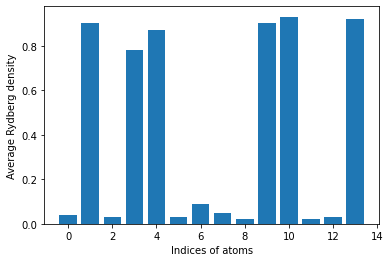

In [27]:
result = device.run(ahs_program_with_shift, blockade_radius=np.sqrt(2) * a, shots=100).result()
# result = device.run(ahs_program_with_shift, shots=100).result()

show_final_avg_density(result)